# Build 2D Poisson Matrix as a Weighted Graph Laplacian 

## Import Libraries 

In [5]:
using LinearAlgebra 
using SparseArrays 

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1:/ Build the Graph Laplacian  
Builds graph Laplacian $A = B^T \, B$ on a uniform mesh assuming x-lexicographical ordering of the nodes. The matrix $B$ here holds the point-edge connectivity (include information on the size of the matrix $B$). The nodes connected to the boundary might still require adjustment. 

### Subsection 1.1/ Build Graph Laplacian 
More text goes here. 

In [25]:
function graph_laplacian_2D(nx,ny)
  nxp1 = nx+1; nyp1 = ny+1; 
  nedges  = nxp1*ny+nx*nyp1;
  npoints = nxp1*nyp1; 
  B = zeros(nedges,npoints)
  k = 1; 
  # edges going from left to right 
  for j=1:nyp1
    for i=1:nx
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+1] = -1; k+=1;
    end
  end
  # edges going to bottom to top 
  for j=1:ny
    for i=1:nxp1
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+nxp1] = -1; k+=1;
    end
  end
  return Transpose(B)*B
end

graph_laplacian_2D (generic function with 1 method)

In [26]:
nx = 3; ny = 3; 
A = graph_laplacian_2D(nx,ny)

16×16 Matrix{Float64}:
  2.0  -1.0   0.0   0.0  -1.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   3.0  -1.0   0.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   3.0  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   2.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   0.0   0.0   0.0   3.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   0.0   0.0  -1.0   4.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   0.0   0.0  -1.0     -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0   0.0      0.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   0.0      0.0   0.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0     -1.0   0.0   0.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   4.0  -1.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0     -1.0   3.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   2.0  -1.0   0.0   0.0
  

## Section 2:  Capacitor Plate Modeling 

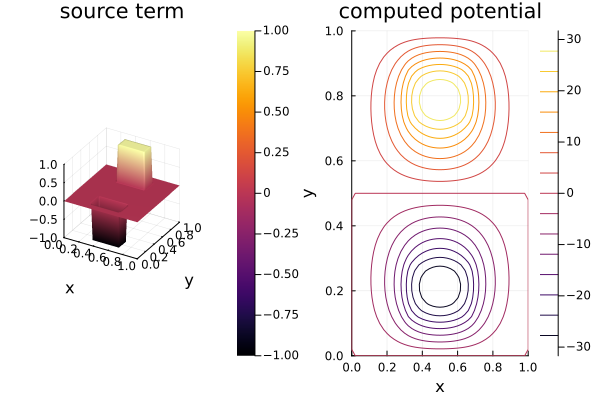

In [23]:
#..set number of intervals (N)
N = 50; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
A1 = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A1 = (1/h2)*A1;
I = Diagonal(e); 
I_bnd = Diagonal(e_bnd); 

#..Construct the 2D matrix using Kronecker products 
Axx = kron(A1,I); 
Ayy = kron(I,A1); 
A = Axx+Ayy; 

nx = N; ny = N; nxp1 = nx+1; nyp1 = ny+1;
nedges  = nxp1*ny+nx*nyp1;
npoints = nxp1*nyp1; 
B = zeros(nedges,npoints)
k = 1; 
# edges going from left to right 
for j=1:nyp1
    for i=1:nx
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+1] = -1; k+=1;
    end
end
# edges going to bottom to top 
for j=1:ny
    for i=1:nxp1
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+nxp1] = -1; k+=1;
    end
end
A = Transpose(B)*B 

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
sourceterm(x,y) = (x>0.3)*(x<0.7)*(y>0.7)*(y<0.9) - (x>0.3)*(x<0.7)*(y>.1)*(y<.3); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 

#..reshape the computed approximation 
U = reshape(u,Np1,Np1); 

#..plot the computed approximation as a contour plot 
p1 = surface(x, y, F, xlabel="x", ylabel="y", title="source term")
p2 = contour(x, y, U, xlabel="x", ylabel="y", title="computed potential")
plot(p1,p2)

## Section 2:/ Build the Graph Laplacian  
Builds graph Laplacian $A = B^T \, D \, B$ on a uniform mesh assuming x-lexicographical ordering of the nodes. The matrix $B$ and $D$ hold the node-edge connectivity and the weights on the edges, respectively. Still need to construct the diagonal matrix $D$. 